# A Basic MLP

This example shows the possibility of building a simple MLP in rendervous using composition of maps.

In [1]:
try: # install all dependencies in colab 
    import google.colab
    !sudo apt-get update -y
    !sudo apt-get install -y libnvidia-gl-555 vulkan-tools glslang-tools vulkan-validationlayers-dev
    !pip install pyav==13.1.0
    !pip install git+https://github.com/rendervous/rendervous_project.git
except:
    print("Executing locally")

Executing locally


D:\rendervous.project\rdv_env\Lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


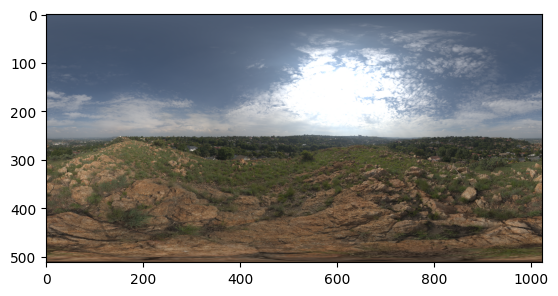

In [2]:
import rendervous as rdv
import vulky.datasets as datasets
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np


# load the example image
# im = rdv.load_image('reconstructed_cloud.png')[..., 0:3].to(rdv.device())
im = datasets.Images.environment_example.cuda()
im = torch.clamp(im ** (1.0/2.2), 0.0, 1.0)

plt.imshow(im.cpu())
plt.show()

[Parameter containing:
tensor([[-1.6628e-01,  7.0026e-01],
        [ 3.7536e-01, -8.2481e-02],
        [-2.6589e-01,  4.5718e-01],
        [ 7.7213e-05, -2.2297e-01],
        [ 3.5935e-01,  6.5958e-01],
        [ 1.1509e-01, -5.7288e-01],
        [ 2.9844e-01,  1.1788e-01],
        [ 2.9058e-01, -6.0271e-01],
        [-5.7591e-01,  2.8951e-01],
        [-6.7968e-01, -6.6342e-01],
        [-2.9320e-01,  5.1600e-01],
        [-6.1156e-01,  1.2562e-02],
        [ 5.0298e-02,  4.8898e-01],
        [-3.2589e-01, -5.7053e-01],
        [ 3.8503e-01,  1.8866e-01],
        [ 5.4423e-01,  8.2062e-02]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([-0.4238, -0.0457,  0.4550,  0.2512, -0.5430,  0.0951, -0.6709, -0.0612,
        -0.0736, -0.2999, -0.7048, -0.5878,  0.6779, -0.2998,  0.0989,  0.2167],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([[ 0.1546,  0.0789,  0.1055, -0.1589, -0.0158, -0.0727, -0.1597, -0.1105,
          0.0681, -0.1776,  0.0

Loss: 0.016468364745378494: 100%|██████████| 500/500 [00:38<00:00, 13.15it/s]


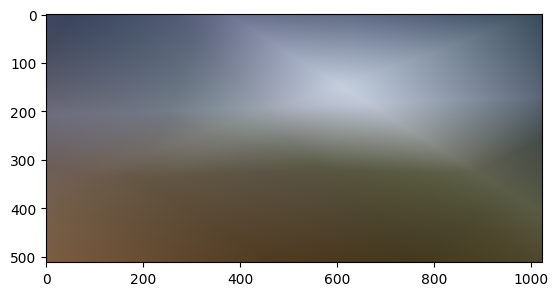

In [3]:
def dense(input_dim, output_dim):
    k = 1 / input_dim
    A_0 = torch.nn.Parameter((torch.rand(output_dim, input_dim, device=rdv.device())*2 - 1)*np.sqrt(k))
    B_0 = torch.nn.Parameter((2 * torch.rand(output_dim, device=rdv.device())-1)*np.sqrt(k))
    return A_0 @ rdv.X + rdv.const[B_0]

maps = [dense(2, 16), rdv.relu, dense(16, 16), rdv.relu, dense(16, 3)]

# mlp_eval = rdv.Sequential(*maps)
mlp = maps[0].then(maps[1]).then(maps[2]).then(maps[3]).then(maps[4])
# mlp = dense(2, 16).then(rdv.relu).then(dense(16, 16)).then(rdv.relu).then(dense(16, 3))

optimizer = torch.optim.AdamW(mlp.parameters(), lr=0.001)

print(list(mlp.parameters()))

x = torch.cartesian_prod(
    torch.arange(-1.0, 1.0, 2.0 / im.shape[0], device=rdv.device()),
    torch.arange(-1.0, 1.0, 2.0 / im.shape[1], device=rdv.device())
).view(im.shape[0], im.shape[1], -1)

mlp(x)  # prewarm

# Evaluation time
with torch.no_grad():
    for test in tqdm(range(1000)):
        y = mlp(x)
        torch.cuda.empty_cache()
    
steps_iterator = tqdm(range(500))
for s in steps_iterator:
    optimizer.zero_grad()
    inf_y = mlp(x)
    loss = torch.nn.functional.mse_loss(inf_y, im)
    loss.backward()
    optimizer.step()

    steps_iterator.set_description_str(f"Loss: {loss.item()}")

with torch.no_grad():
    plt.imshow(mlp(x).cpu())
    plt.show()

Casting input dimension of map ReluMap at index 0 to => 16
Casting input dimension of map ReluMap at index 2 to => 16
Backward technique is => technique_1
=============== Sequential Code =================

FORWARD {
    float _intermediate_0[16];
forward(parameters.map_0, _input, _intermediate_0);
float _intermediate_1[16];
forward(parameters.map_1, _intermediate_0, _intermediate_1);
float _intermediate_2[16];
forward(parameters.map_2, _intermediate_1, _intermediate_2);
float _intermediate_3[16];
forward(parameters.map_3, _intermediate_2, _intermediate_3);
forward(parameters.map_4, _intermediate_3, _output);
}

BACKWARD {
    
//Defining the checkpoints

float checkpoint_0[16];

//Filling the checkpoints

float _intermediate_0[16];
forward(parameters.map_0, _input, _intermediate_0);
float _intermediate_1[16];
forward(parameters.map_1, _intermediate_0, _intermediate_1);
float _intermediate_2[16];
forward(parameters.map_2, _intermediate_1, _intermediate_2);
forward(parameters.map_3, _int

Loss: 0.008501021191477776: 100%|██████████| 500/500 [00:40<00:00, 12.23it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1328547..1.1607816].


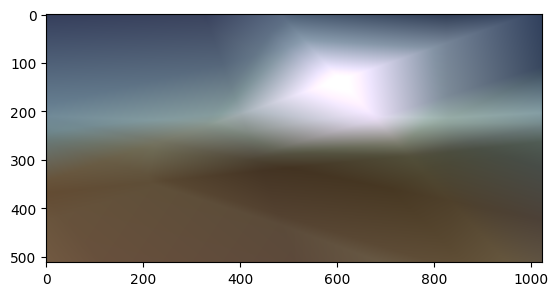

In [4]:
mlp_opt = rdv.Sequential(
    rdv.LinearNode(2, 16),
    rdv.MapNode(rdv.relu),
    rdv.LinearNode(16, 16),
    rdv.MapNode(rdv.relu),
    rdv.LinearNode(16, 3),
    distance_between_checkpoints=3
).build()

optimizer = torch.optim.NAdam(mlp_opt.parameters(), lr=0.002)

x = torch.cartesian_prod(
    torch.arange(-1.0, 1.0, 2.0 / im.shape[0], device=rdv.device()),
    torch.arange(-1.0, 1.0, 2.0 / im.shape[1], device=rdv.device())
).view(im.shape[0], im.shape[1], -1)

mlp_opt(x)  # prewarm

# Evaluation time
with torch.no_grad():
    for test in tqdm(range(1000)):
        y = mlp_opt(x)
        torch.cuda.empty_cache()
    
steps_iterator = tqdm(range(500))
for s in steps_iterator:
    optimizer.zero_grad()
    inf_y = mlp_opt(x)
    loss = torch.nn.functional.mse_loss(inf_y, im)
    loss.backward()
    optimizer.step()

    steps_iterator.set_description_str(f"Loss: {loss.item()}")

with torch.no_grad():
    plt.imshow(mlp_opt(x).cpu())
    plt.show()

Loss: 0.01050564181059599: 100%|██████████| 500/500 [00:02<00:00, 185.21it/s] 
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06639248..1.049053].


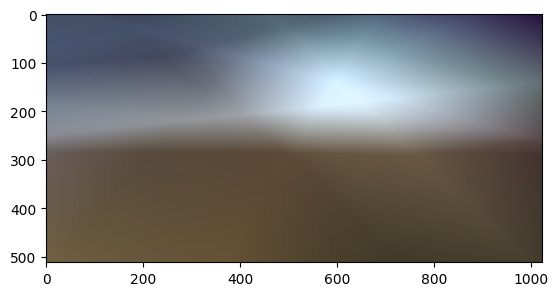

In [5]:
# Equivalent torch mlp
mlp = torch.nn.Sequential(
    torch.nn.Linear(2, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 3)
).to(rdv.device())

optimizer = torch.optim.NAdam(mlp.parameters(), lr=0.002)

x = torch.cartesian_prod(
    torch.arange(-1.0, 1.0, 2.0 / im.shape[0], device=rdv.device()),
    torch.arange(-1.0, 1.0, 2.0 / im.shape[1], device=rdv.device())
).view(im.shape[0], im.shape[1], -1)

# Evaluation time
for test in tqdm(range(1000)):
    y = mlp(x)
    torch.cuda.empty_cache()

steps_iterator = tqdm(range(500))
for s in steps_iterator:
    optimizer.zero_grad()
    inf_y = mlp(x)
    loss = torch.nn.functional.mse_loss(inf_y, im)
    loss.backward()
    optimizer.step()

    steps_iterator.set_description_str(f"Loss: {loss.item()}")

with torch.no_grad():
    plt.imshow(mlp(x).cpu())
    plt.show()